In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings, os
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%HTML
<div>
<style>
td {
  font-size: 32px
}
th {
  font-size: 40px
}
</style>


# Data Access and Harmonization

* Internal workings of data source evaluation 
* Available data sources
* Interpolation (what's supported, how to define it)
* Caching




# Internal Workings of Data Source Evaluation

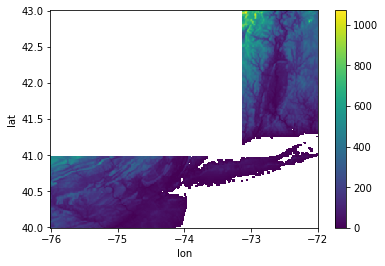

In [19]:
# Import libraries
import podpac
from podpac.datalib.terraintiles import TerrainTiles
from podpac import clinspace, Coordinates

# Create a datasource Node
node = TerrainTiles()

# create coordinates to get tiles
c = Coordinates([clinspace(40, 43, 256), clinspace(-76, -72, 256)], dims=['lat', 'lon'])

# evaluate node
o = node.eval(c)

# Plot the results
o.plot()
pass

```python
terrain.eval(coords)
```

In [4]:
%%HTML
<video width="80%" controls><source src="../Images/podpac-eval.mp4" type="video/mp4"></video>

# Generic DataSource Types
* Local sources
    * Array:    Numpy array stored in RAM
    * Dataset:  Xarray datasets stored in RAM or as xarray-supported files (geotiff, netcdf, zarr, ...)
    * CSV:      CSV files
    * H5PY:     HDF5 files
    * Rasterio: Geotiff, GRIB, hdf5, ... files
    * Zarr:     Zarr files
* Remote sources
    * WCS:      OGC-compliant WCS sources
    * Zarr:     Zarr files stored on S3
    * Rasterio: Geotiffs store on S3
    * PyDAP:    OpenDAP sources
    
Specific data sources, such as `TerrainTiles` and `SMAP` are created from these generic types

In [5]:
dir(podpac.data)

['Array',
 'CSV',
 'DataSource',
 'Dataset',
 'H5PY',
 'INTERPOLATION_DEFAULT',
 'INTERPOLATION_METHODS',
 'INTERPOLATION_METHODS_DICT',
 'INTERPOLATORS',
 'INTERPOLATORS_DICT',
 'Interpolation',
 'InterpolationException',
 'PyDAP',
 'Rasterio',
 'ReprojectedSource',
 'WCS',
 'Zarr',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'interpolation_trait']

# Interpolation Methods

Once the dataset is read through PODPAC, it can be re-interpolated automatically to a different coordinate system.

The default interpolation method is `nearest` for nearest-neighbor interpolation. 



In [7]:
print(podpac.data.INTERPOLATION_DEFAULT)

nearest


Existing interpolation **methods** include:

In [8]:
print(podpac.data.INTERPOLATION_METHODS)

['nearest_preview', 'nearest', 'bilinear', 'cubic', 'cubic_spline', 'lanczos', 'average', 'mode', 'gauss', 'max', 'min', 'med', 'q1', 'q3', 'spline_2', 'spline_3', 'spline_4']


**Note**: `nearest_preview` is useful for rapid visualization, but is approximate.

# Interpolators 
* Various different interpolators handle interpolation between grids, lines, points, ...
* Not all combinations are implemented
* PODPAC selects the most appropriate interpolator for a particular method automatically

In [9]:
print(podpac.data.INTERPOLATORS_DICT.keys())

dict_keys(['NearestNeighbor', 'NearestPreview', 'Rasterio', 'ScipyPoint', 'ScipyGrid'])


# Basic Interpolation Specification (1/2)

1. Nearest-neighbor for all dimensions

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj: elevation-tiles-prod/geotiff/4/4/6.tif


OrderedDict([(('lon', 'lat'), NearestNeighbor (nearest))])

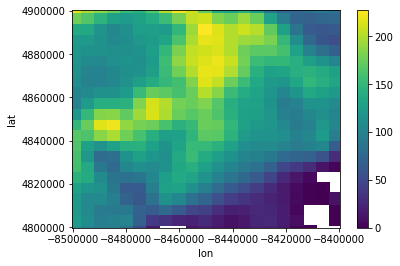

In [10]:
# Specify coordinates for evaluating node
coords = Coordinates([clinspace(4800000, 4900000, 256), clinspace(-8500000, -8400000, 256)],
                     dims=['lat', 'lon'], crs='epsg:3857')

# Create the node with the desired interpolation
node_near = TerrainTiles(interpolation='nearest', zoom=4)  # Nearest is also the default

# Evaluate the node and plot
o = node_near.eval(coords)
o.plot()

# Let's see what interpolator PODPAC selected
node_near.sources[0].interpolators

# Basic Interpolation Specification (2/2)

2. Bi-linear for all dimensions

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj: elevation-tiles-prod/geotiff/4/4/6.tif


OrderedDict([(('lon', 'lat'), Rasterio (bilinear))])

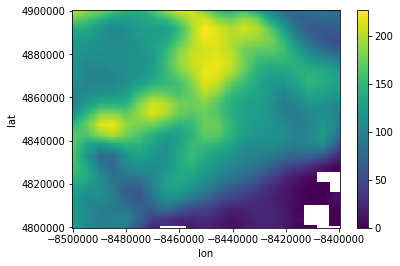

In [11]:
node_bilinear = TerrainTiles(interpolation='bilinear', zoom=4)  
o = node_bilinear.eval(coords)
o.plot()
node_bilinear.sources[0].interpolators

# Interpolation Parameters
Different **interpolators** have paramaters that can be specified.

The `NearestNeighbor` interpolator understands the `spatial_tolerance` parameter.

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj: elevation-tiles-prod/geotiff/4/4/6.tif


OrderedDict([(('lon', 'lat'), NearestNeighbor (nearest))])

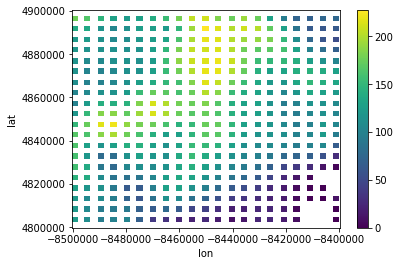

In [12]:
interpolation = {'method': 'nearest',
                 'params': {
                      'spatial_tolerance': 1000  # Only return data if within 1000 units of datapoint
                }}
node_near_tol = TerrainTiles(interpolation=interpolation, zoom=4) 
o = node_near_tol.eval(coords)
o.plot()
node_near_tol.sources[0].interpolators  

# Interpolation Parameters Gotcha 
When non-uniform coordinates are used, the `NearestNeighbor` interpolator cannot be used. 

The `ScipyGrid` interpolator **does not** understand the `spatial_tolerance` parameter. 

OrderedDict([(('lon', 'lat'), ScipyGrid (nearest))])

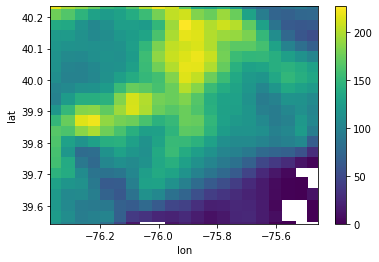

In [13]:
# Coordinates that are not in the native CRS will not be uniform
coords2 = Coordinates([clinspace(39.544, 40.233, 256), clinspace(-76.367, -75.458, 256)],
                       dims=['lat', 'lon'], crs='epsg:4326')
# Evaluating SAME NODE again gives different results
o = node_near_tol.eval(coords2)
o.plot()
node_near_tol.sources[0].interpolators

# Advanced Interpolation Specification
* Can specify different interpolators for different dimensions
    * In most cases lat/lon should go together
* Can specify exactly which interpolator should be used, or a new order of interpolators
```python
interpolation = [
    {   'method': "method_name",
        'params': {"param_1": "value", ...}
        'interpolators': [Interpolator1, Interpolator2, ...]
        'dims': ['dim1', 'dim2']
    }, {
        'method': "method_name",
        ...,
        'dims': ['dim3', 'dim4']
    }]
```

# Advanced Example
This is the same as the first example, except here we are:
* Forcing the `ScipyGrid` interpolator instead of the `NearestNeighbor` interpolator
* Showing how to choose a different interpolation for the time dimension, even though this doesn't have time. 

In [14]:
interpolation =[ 
    {
        'method': 'nearest',
        'interpolators': [podpac.interpolators.ScipyGrid],
        'dims': ['lat', 'lon']
    }, { 
        'method': 'bilinear',
        'dims': 'time'
    }
]
node_near_tol = TerrainTiles(interpolation=interpolation, zoom=4) 
o = node_near_tol.eval(coords)
o.plot()
node_near_tol.sources[0].interpolators  

TraitError: The 'interpolation' trait of a TerrainTiles instance must be a dict or any of ['nearest_preview', 'nearest', 'bilinear', 'cubic', 'cubic_spline', 'lanczos', 'average', 'mode', 'gauss', 'max', 'min', 'med', 'q1', 'q3', 'spline_2', 'spline_3', 'spline_4'] or an Interpolation, but a value of [{'method': 'nearest', 'interpolators': [<class 'podpac.core.data.interpolators.ScipyGrid'>], 'dims': ['lat', 'lon']}, {'method': 'bilinear', 'dims': 'time'}] <class 'list'> was specified.

# Caching

To reduce the amount of data downloading, PODPAC supports in-memory (ram), disk, and cloud (S3) caching of datasets.


In [ ]:
# Create evaluation coordinates
coords = Coordinates([clinspace(4800000, 4900000, 256), clinspace(-8500000, -8400000, 256)],
                     dims=['lat', 'lon'], crs='epsg:3857')

In [20]:
# Create two instances of the same type of node
node1 = TerrainTiles()  
node2 = TerrainTiles()  

# Evaluate nodes
o = node1.eval(coords) # Evalute node1 the first time
print ("node1 evaluation 1 from cache?", node1._from_cache)  # The data is NOT cached
o = node1.eval(coords) # Evaluate node 1 again
print ("node1 evaluation 2 from cache?", node1._from_cache)  # The data was cached
o = node2.eval(coords) # Evaluate node2 the first time
print ("node2 evaluation 1 from cache?", node2.sources[0]._from_cache)  # The data came from the cache!

node1 evaluation 1 from cache? False
node1 evaluation 2 from cache? True
node2 evaluation 1 from cache? True


Node2 also gets its data from cache because it has the same definition as Node1

In [ ]:
print("node1 and node2 definitions are the same?", node2.sources[0].json == node1.sources[0].json)

# Controlling Cache Behavior Globally
Default caching behavior is controlled through `podpac.settings`.



|podpac.setting[] | Value | Description |
|:-----------------|-------|:-------------|
|DEFAULT_CACHE 		     |    ['ram'] | 	 May contain 'disk', 'ram', and 's3'|
|CACHE_OUTPUT_DEFAULT 	 |True 		  |If True, will cache node outputs.|
|RAM_CACHE_ENABLED   	 |    True 	  |If False, globally disables ram cache.|
|RAM_CACHE_MAX_BYTES 	 |1000000000.0 |Limits maximum RAM used by cache.|
|DISK_CACHE_ENABLED 	 |True 		 |If False, globally disables disk cache.|
|DISK_CACHE_DIR 	     |cache 	 |	 Path to cache directory. If not absolute, is relative to "settings.ROOT_PATH".|
|DISK_CACHE_MAX_BYTES 	 |None 		 |Limits maximum disk space used by cache.|
|S3_CACHE_ENABLED 	     |True 		 |If False, globally disables s3 cache.|
|S3_CACHE_DIR 		     |cache 	 |	 Path to cache bucket. This is relative to "settings.S3_BUCKET_NAME".|
|S3_CACHE_MAX_BYTES 	 |None 		 |Limits maximum disk space used by cache.|

In [ ]:
print("DEFAULT_CACHE: \t\t", podpac.settings['DEFAULT_CACHE'], "\t May contain 'disk', 'ram', and 's3'")
print("CACHE_OUTPUT_DEFAULT: \t", podpac.settings['CACHE_OUTPUT_DEFAULT '], "\t\t If True, will cache node outputs.")
print("RAM_CACHE_ENABLED: \t", podpac.settings['RAM_CACHE_ENABLED'], "\t\t If False, globally disables ram cache.")
print("RAM_CACHE_MAX_BYTES: \t", podpac.settings['RAM_CACHE_MAX_BYTES'], '\t Limits maximum RAM used by cache.')
print("DISK_CACHE_ENABLED: \t", podpac.settings['DISK_CACHE_ENABLED  '], '\t\t If False, globally disables disk cache.')
print("DISK_CACHE_DIR: \t", podpac.settings['DISK_CACHE_DIR'], '\t\t Path to cache directory. If not absolute, is relative to "settings.ROOT_PATH".')
print("DISK_CACHE_MAX_BYTES: \t", podpac.settings['DISK_CACHE_MAX_BYTES  '], '\t\t Limits maximum disk space used by cache.')
print("S3_CACHE_ENABLED: \t", podpac.settings['S3_CACHE_ENABLED'], '\t\t If False, globally disables s3 cache.')
print("S3_CACHE_DIR: \t\t", podpac.settings['S3_CACHE_DIR'], '\t\t Path to cache bucket. This is relative to "settings.S3_BUCKET_NAME".')
print("S3_CACHE_MAX_BYTES: \t", podpac.settings['S3_CACHE_MAX_BYTES  '], '\t\t Limits maximum disk space used by cache.')


# Controlling Cache Behavior for Node
Each node can have its individual cache behavior set.

In [15]:
node = TerrainTiles(zoom=5,
    cache_output=True,         # Automatically caches outputs, overwriting global setting
    cache_ctrl=['ram', 'disk'] # Prefer caching and retrieval from cache looking at ram then disk
)

In [16]:
os.listdir(os.path.join(podpac.settings['ROOT_PATH'], podpac.settings["DISK_CACHE_DIR"], 'podpac', 'datalib'))

['smap']

In [17]:
o = node.eval(coords)

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj: elevation-tiles-prod/geotiff/5/9/12.tif


In [23]:
os.listdir(os.path.join(podpac.settings['ROOT_PATH'], podpac.settings["DISK_CACHE_DIR"], 'podpac', 'datalib'))

['smap', 'terraintiles']

For this example, after the eval, the data will never be downloaded and always come from ram or disk whenever the SAME coordinates are evaluated. 

# Clearing Cache
To completely clear all the cache for a certain cache store type (one of 'ram', 'disk', 's3') use: 
```python
podpac.clear_cache(cache_store_type)
```

To clear the cache for a particular node type use:

In [22]:
node.rem_cache(key='output', coordinates=coords, mode='disk')

# Exercises


* Create a node to retrieve SMAP data
* Set the interpolation type to `bilinear`
* Set up the node so that results will not be cached
* Evaluate the node using `coords` and plot the results